# Modelling using value of R0

##### Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [4839]:
import pandas as pd, numpy as np, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV

# Librerías para plots
from sklearn import tree
#import graphviz
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Read file and prepare data 

In [4840]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
del df['deaths_prev_18']
del df['Excess mortality P-scores, all ages']
#del df['Excess mortality P-scores, all ages Prev 18 days']
del df['average_deaths_2015_2019_all_ages']
del df['deaths']
del df['month']
del df['life_expectancy']
del df['%df_population_gr_65']
del df['UN Population Division (Median Age) (2017)']
del df['nurses_per_1000']
del df['doctors_per_1000']
del df['beds_per_1000']

#del df['number_of_arrivals']
#del df['doctors_per_1000']
#del df['nurses_per_1000']
#del df['beds_per_1000']
#del df['urban_population']
#del df['life_expectancy']
#del df['%youth_unemployment_total']

df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,Holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,"Excess mortality P-scores, all ages Prev 18 days",accumulated,R0
0,AUS,2020-03-08,1.05,1.72,-0.74,4.98,-2.09,7.93,2.00,1.00,...,0.00,23.57,0.11,8263000.00,85.90,nan,11.84,6.18,0.00,0.99
1,AUS,2020-03-15,0.76,1.51,-1.29,7.70,-0.82,10.57,2.00,1.00,...,0.00,22.45,0.13,8263000.00,85.90,nan,11.84,4.53,0.00,1.00
2,AUS,2020-03-22,1.29,3.37,-1.08,9.35,0.94,10.88,2.00,1.00,...,0.00,21.81,0.16,8263000.00,85.90,nan,11.84,4.92,0.00,1.02
3,AUS,2020-03-29,0.71,8.98,-0.39,5.45,-2.86,8.33,2.00,1.00,...,0.00,21.35,0.14,8263000.00,85.90,nan,11.84,4.67,0.00,1.07
4,AUS,2020-04-05,-0.90,15.16,0.45,-1.06,-4.96,6.96,2.00,1.00,...,0.00,21.18,0.05,8263000.00,85.90,nan,11.84,4.62,0.00,1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.69,-4.06,10.18,-36.04,-19.76,-28.10,1.00,3.00,...,0.00,2.89,0.05,75608000.00,82.06,nan,8.30,41.25,0.18,0.97
2038,USA,2021-01-17,-22.78,-3.98,12.65,-38.88,-16.65,-42.08,1.00,3.00,...,1.00,1.71,0.07,75608000.00,82.06,nan,8.30,41.07,0.19,0.95
2039,USA,2021-01-24,-23.63,-9.84,14.06,-41.02,-15.86,-41.71,1.00,3.00,...,1.00,2.50,0.09,75608000.00,82.06,0.17,8.30,44.75,0.20,0.89
2040,USA,2021-01-31,-23.98,-11.39,11.45,-39.57,-22.59,-29.00,1.00,3.00,...,0.00,1.20,0.04,75608000.00,82.06,0.51,8.30,36.74,0.21,0.91


In [4841]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'number_of_arrivals', 'urban_population', 'total_vaccinations_per_100',
       '%youth_unemployment_total',
       'Excess mortality P-scores, all ages Prev 18 days', 'accumulated',
       'R0'],
      dtype='object')

## Feature Engineering

In [4842]:
df['number_of_arrivals']=df['number_of_arrivals']*df['international_travel_controls']
df['%youth_unemployment_total']=df['%youth_unemployment_total']*df['retail_and_recreation']

Text(0.5, 1.0, 'R0')

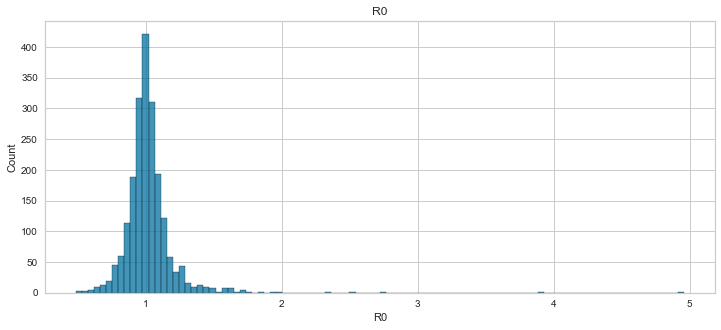

In [4843]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes);
axes.set_title('R0')

In [4844]:
df['R0'].describe()

count   2042.00
mean       1.02
std        0.19
min        0.48
25%        0.94
50%        1.00
75%        1.07
max        4.96
Name: R0, dtype: float64

In [4845]:
#df['total_vaccinations_per_100']=df['total_vaccinations_per_100'].apply(lambda x : x if x > 0 else 0)

In [4846]:
#df=df.fillna(df.median())

In [4847]:
X=df[df.columns[2:-1]]
y=df['R0']

## Apply model and view results 

pip install xgboost

In [4848]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor

## XGBoost Regressor 

### GridSearchCV 

In [4849]:
import warnings
warnings.filterwarnings('ignore')

In [4850]:
from sklearn.metrics import fbeta_score, make_scorer
def mape_fun(pred, train):
            
    return np.mean(np.abs((pred - train) / train)) * 100


custom_scorer = make_scorer(mape_fun)

In [ ]:
def new_func(pred, train):
    res_df_test[(res_df_test['test']>1) & (res_df_test['pred']<1)].count()[0]

In [4880]:
from sklearn.model_selection import StratifiedKFold
# A parameter grid for XGBoost
params = {'gamma':[i/10.0 for i in range(1,3)], 'max_depth': [5,6,7]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(num_boost_rounds=1000) 

grid = GridSearchCV(xgb, params, verbose=1, n_jobs=-1, scoring=custom_scorer)

import datetime
date1=pd.Timestamp(2020, 1, 1)
date2=pd.Timestamp(2020, 5, 1)

X_1=df[(pd.to_datetime(df['Date']) <= date1) | (pd.to_datetime(df['Date']) >= date2)]
X_2=df[(pd.to_datetime(df['Date']) > date1) & (pd.to_datetime(df['Date']) < date2)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

In [4909]:
import datetime
date1=pd.Timestamp(2020, 12, 1)

X_1=df[(pd.to_datetime(df['Date']) <= date1)]
X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

In [4882]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [4910]:
%%time
x=grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.2s finished


[13:58:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 686 ms, sys: 16.4 ms, total: 703 ms
Wall time: 7.67 s


In [4911]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_boost_rounds=1000,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [4936]:
grid.best_score_

10.55400188420521

In [4937]:
k = 4
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    grid.fit(X_train, y_train)
    pred_values = grid.best_estimator_.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.2s finished


[14:00:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


[14:00:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.0s finished


[14:00:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.7s finished


[14:00:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [4939]:
acc_score

[9.155280742977014, 10.275433284744954, 15.144587119026049, 10.071884342450858]

In [4940]:
acc_score

[9.155280742977014, 10.275433284744954, 15.144587119026049, 10.071884342450858]

## Model evaluation metrics

### Test Set

In [4913]:
y_pred=grid.best_estimator_.predict(X_test)

In [4914]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.14395115057509328
mse score is 0.03203900906173931
rmse score is 0.1789944386335489
r2 score is -0.7960026415075188
mape score is 16.064103682991362


## Train Set

In [4915]:
y_pred_train=grid.best_estimator_.predict(X_train)

In [4916]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.06708780129269304
mse score is 0.010244385706102898
rmse score is 0.10121455283753862
r2 score is 0.7529094035350186
mape score is 6.271567444526591


In [4917]:
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
39,0.99,1.04,0.04
40,1.03,1.04,0.01
41,1.03,1.02,0.01
42,0.98,1.06,0.08
47,0.91,1.20,0.29
...,...,...,...
2037,0.97,1.00,0.04
2038,0.95,0.99,0.04
2039,0.89,0.99,0.09
2040,0.91,1.01,0.10


Text(0.5, 1.0, 'R0_Predicted')

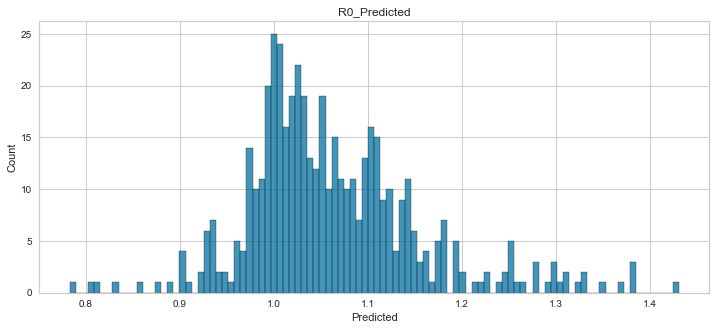

In [4918]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

Text(0.5, 1.0, 'R0_Actual')

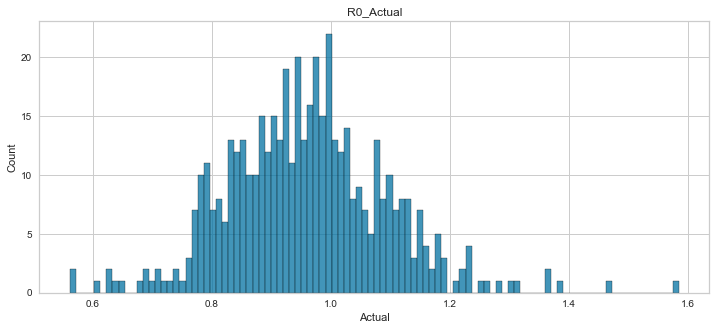

In [4919]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model evaluation plots

### Difference Histogram 

Text(0.5, 1.0, 'Difference Histogram')

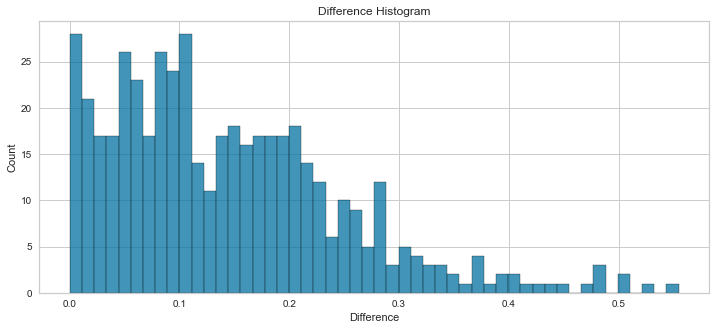

In [4920]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

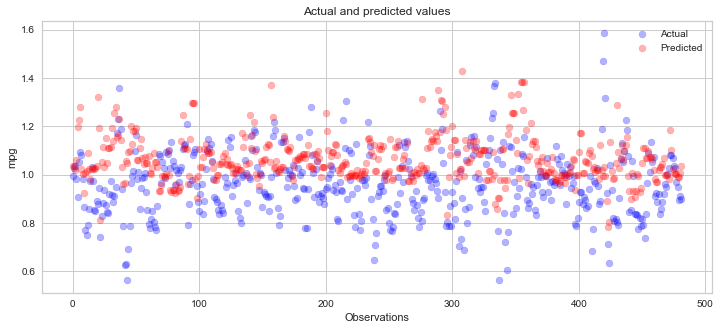

In [4921]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

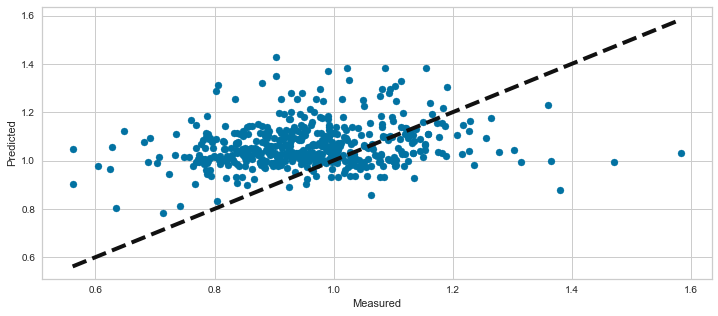

In [4922]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

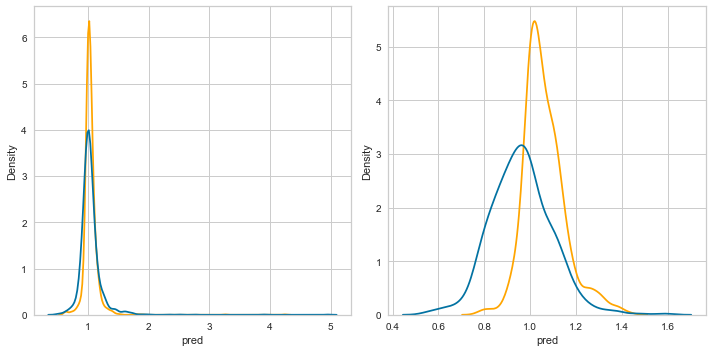

In [4923]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [4925]:
mae_test = np.round(res_df_test['dif_abs'].mean(),2)
gae_test = np.round(res_df_test['dif_abs'].sum(),2)
error_test_rate_abs = np.round(100*gae_test/res_df_test['test'].sum(),2)
error_test = np.round(res_df_test['dif'].sum(),2)
error_test_rate = np.round(100*error_test/res_df_test['test'].sum(),2)
print('El error absoluto medio es: ', mae_test)
print('El error global es: ', error_test)
print('La tasa de error global es: %',error_test_rate)

El error absoluto medio es:  0.14
El error global es:  49.1
La tasa de error global es: % 10.61


In [4926]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1426,0.88,1.38,-0.50,0.50,-36.29
1746,1.03,1.58,-0.55,0.55,-35.01
1745,0.99,1.47,-0.48,0.48,-32.45
1425,1.00,1.37,-0.37,0.37,-26.89
1747,0.99,1.31,-0.32,0.32,-24.48
...,...,...,...,...,...
1474,0.98,0.60,0.37,0.37,61.63
1173,1.31,0.81,0.51,0.51,62.94
198,1.06,0.63,0.43,0.43,68.31
1018,1.12,0.65,0.47,0.47,72.83


In [4927]:
res_df_test[(res_df_test['test']>1)].count()[0]

165

In [4928]:
res_df_test[(res_df_test['test']>1) & (res_df_test['pred']<1)].count()[0]

37

In [4929]:
np.abs(res_df_test['dif_abs']).mean()/res_df_test['test'].sum()

0.0003109429030100838

In [4930]:
np.abs(res_df_test['dif%']).mean()

16.064024896265554

In [4931]:
#MAPE value
np.abs(res_df_test['dif%']).describe()

count   482.00
mean     16.06
std      13.40
min       0.02
25%       5.92
50%      12.63
75%      22.45
max      86.09
Name: dif%, dtype: float64

In [4932]:
np.abs(res_df_test['test']).describe()

count   482.00
mean      0.96
std       0.13
min       0.56
25%       0.87
50%       0.96
75%       1.03
max       1.58
Name: test, dtype: float64

In [4933]:
np.abs(res_df_test['pred']).describe()

count   482.00
mean      1.06
std       0.09
min       0.78
25%       1.00
50%       1.05
75%       1.11
max       1.43
Name: pred, dtype: float64

## Feature importance 

In [4934]:
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

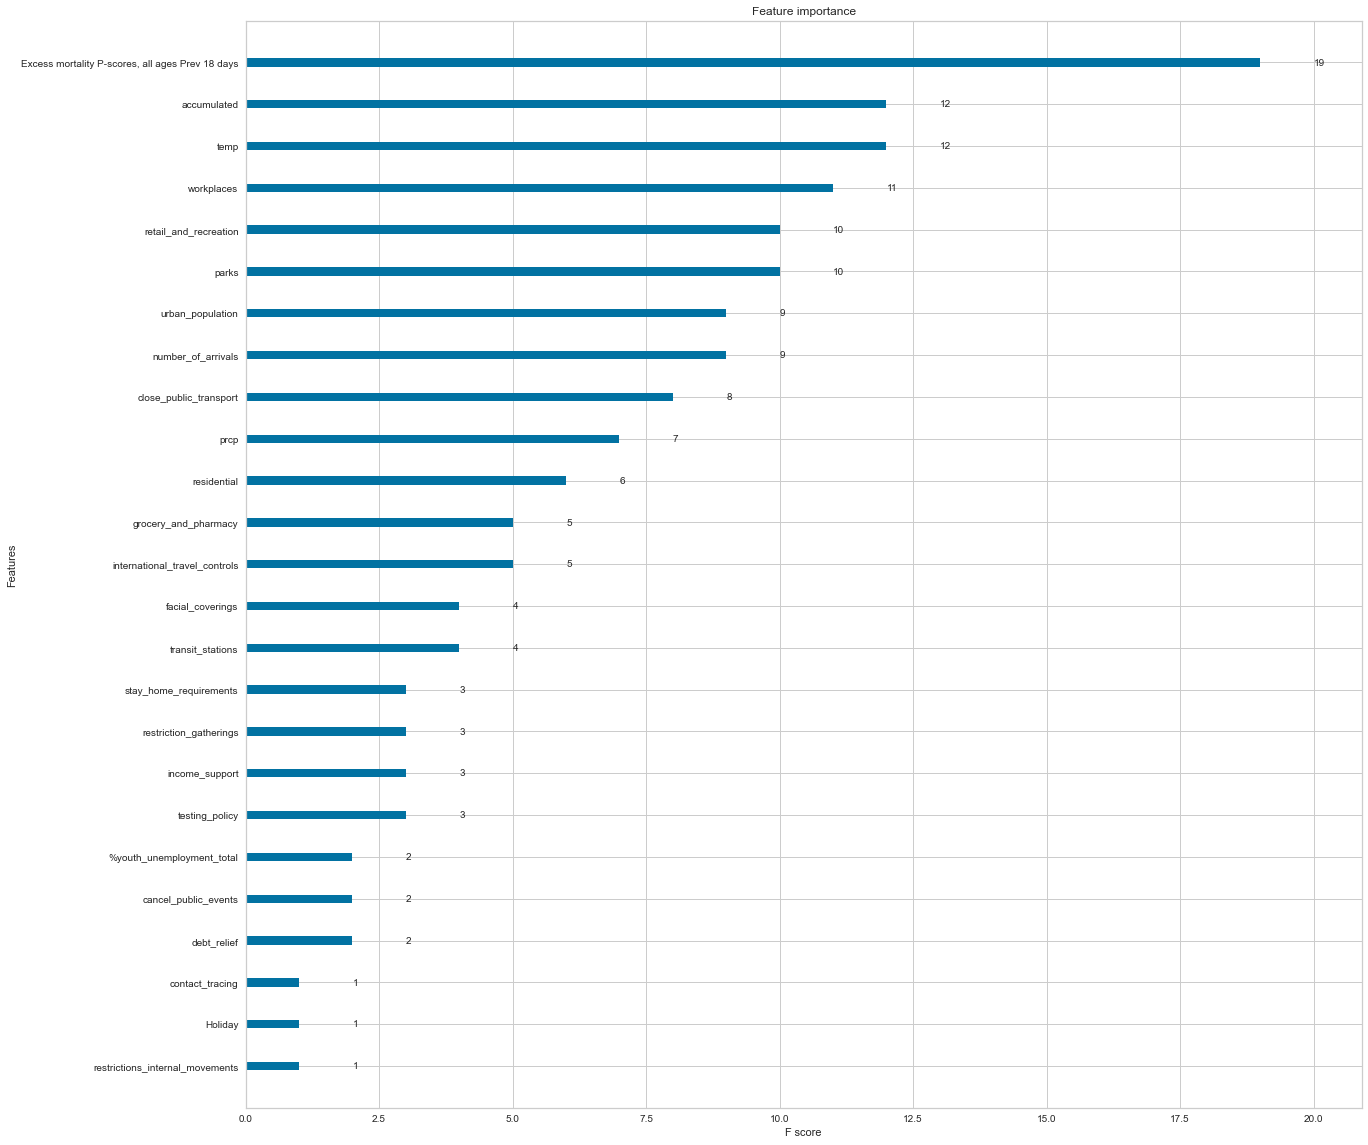

In [4935]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [2191]:
import lightgbm as lgb

In [3769]:
hyper_params = {
    'metric': ['mape'],
    "max_depth": 15,
    "num_leaves": 256,  
    "max_bin": 512,
    "num_iterations": 10000,
    "n_estimators": 20
}

In [3770]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [3771]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mape',
        early_stopping_rounds=1000)

[1]	valid_0's mape: 0.127414
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's mape: 0.12439
[3]	valid_0's mape: 0.119795
[4]	valid_0's mape: 0.117028
[5]	valid_0's mape: 0.114574
[6]	valid_0's mape: 0.113879
[7]	valid_0's mape: 0.112803
[8]	valid_0's mape: 0.111123
[9]	valid_0's mape: 0.110601
[10]	valid_0's mape: 0.108331
[11]	valid_0's mape: 0.108528
[12]	valid_0's mape: 0.107864
[13]	valid_0's mape: 0.108165
[14]	valid_0's mape: 0.10768
[15]	valid_0's mape: 0.107763
[16]	valid_0's mape: 0.106828
[17]	valid_0's mape: 0.107078
[18]	valid_0's mape: 0.107238
[19]	valid_0's mape: 0.108177
[20]	valid_0's mape: 0.109712
[21]	valid_0's mape: 0.110557
[22]	valid_0's mape: 0.110677
[23]	valid_0's mape: 0.11064
[24]	valid_0's mape: 0.110928
[25]	valid_0's mape: 0.110821
[26]	valid_0's mape: 0.110982
[27]	valid_0's mape: 0.11128
[28]	valid_0's mape: 0.11157
[29]	valid_0's mape: 0.111789
[30]	valid_0's mape: 0.111989
[31]	valid_0's mape: 0.112083
[32]	valid_0's mape: 

[294]	valid_0's mape: 0.123647
[295]	valid_0's mape: 0.123654
[296]	valid_0's mape: 0.123695
[297]	valid_0's mape: 0.123724
[298]	valid_0's mape: 0.12373
[299]	valid_0's mape: 0.123717
[300]	valid_0's mape: 0.123683
[301]	valid_0's mape: 0.123654
[302]	valid_0's mape: 0.123658
[303]	valid_0's mape: 0.123655
[304]	valid_0's mape: 0.123657
[305]	valid_0's mape: 0.123678
[306]	valid_0's mape: 0.12367
[307]	valid_0's mape: 0.123651
[308]	valid_0's mape: 0.123651
[309]	valid_0's mape: 0.12365
[310]	valid_0's mape: 0.123653
[311]	valid_0's mape: 0.123665
[312]	valid_0's mape: 0.123661
[313]	valid_0's mape: 0.123669
[314]	valid_0's mape: 0.123623
[315]	valid_0's mape: 0.12364
[316]	valid_0's mape: 0.123637
[317]	valid_0's mape: 0.123674
[318]	valid_0's mape: 0.123676
[319]	valid_0's mape: 0.123685
[320]	valid_0's mape: 0.123673
[321]	valid_0's mape: 0.123774
[322]	valid_0's mape: 0.123772
[323]	valid_0's mape: 0.123763
[324]	valid_0's mape: 0.123769
[325]	valid_0's mape: 0.123769
[326]	valid_

[583]	valid_0's mape: 0.124664
[584]	valid_0's mape: 0.124663
[585]	valid_0's mape: 0.124653
[586]	valid_0's mape: 0.124661
[587]	valid_0's mape: 0.12467
[588]	valid_0's mape: 0.124683
[589]	valid_0's mape: 0.124679
[590]	valid_0's mape: 0.124682
[591]	valid_0's mape: 0.124689
[592]	valid_0's mape: 0.124704
[593]	valid_0's mape: 0.124707
[594]	valid_0's mape: 0.12471
[595]	valid_0's mape: 0.124715
[596]	valid_0's mape: 0.124718
[597]	valid_0's mape: 0.124732
[598]	valid_0's mape: 0.124739
[599]	valid_0's mape: 0.124736
[600]	valid_0's mape: 0.124723
[601]	valid_0's mape: 0.124742
[602]	valid_0's mape: 0.12472
[603]	valid_0's mape: 0.124724
[604]	valid_0's mape: 0.124724
[605]	valid_0's mape: 0.124724
[606]	valid_0's mape: 0.124725
[607]	valid_0's mape: 0.124717
[608]	valid_0's mape: 0.124706
[609]	valid_0's mape: 0.124712
[610]	valid_0's mape: 0.124708
[611]	valid_0's mape: 0.124699
[612]	valid_0's mape: 0.12473
[613]	valid_0's mape: 0.124717
[614]	valid_0's mape: 0.12471
[615]	valid_0

[870]	valid_0's mape: 0.124714
[871]	valid_0's mape: 0.124714
[872]	valid_0's mape: 0.124715
[873]	valid_0's mape: 0.124721
[874]	valid_0's mape: 0.12471
[875]	valid_0's mape: 0.124711
[876]	valid_0's mape: 0.124709
[877]	valid_0's mape: 0.124713
[878]	valid_0's mape: 0.124714
[879]	valid_0's mape: 0.124716
[880]	valid_0's mape: 0.124716
[881]	valid_0's mape: 0.124716
[882]	valid_0's mape: 0.124716
[883]	valid_0's mape: 0.124713
[884]	valid_0's mape: 0.124705
[885]	valid_0's mape: 0.124705
[886]	valid_0's mape: 0.124713
[887]	valid_0's mape: 0.124715
[888]	valid_0's mape: 0.124715
[889]	valid_0's mape: 0.124715
[890]	valid_0's mape: 0.124703
[891]	valid_0's mape: 0.124702
[892]	valid_0's mape: 0.124704
[893]	valid_0's mape: 0.124715
[894]	valid_0's mape: 0.124719
[895]	valid_0's mape: 0.124724
[896]	valid_0's mape: 0.124722
[897]	valid_0's mape: 0.124723
[898]	valid_0's mape: 0.12472
[899]	valid_0's mape: 0.124714
[900]	valid_0's mape: 0.124711
[901]	valid_0's mape: 0.124712
[902]	vali

LGBMRegressor(max_bin=512, max_depth=15, metric=['mape'], n_estimators=20,
              num_iterations=10000, num_leaves=256)

In [3772]:
def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [3773]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

In [3774]:
mape(y_pred, y_test)

11.29330318433407

In [3777]:
r = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [3778]:
mape(r, y_train)

6.109584711318826

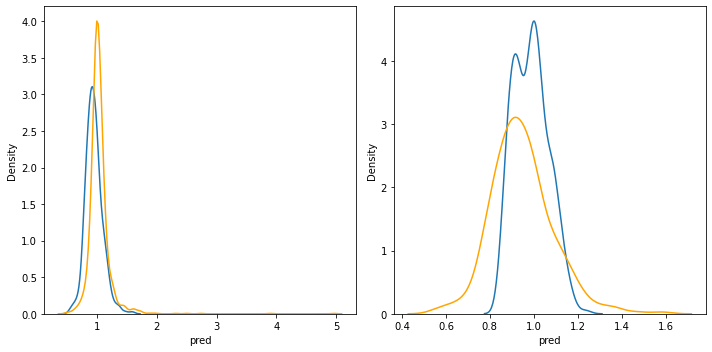

In [3775]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_test

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1], color='orange')
fig.tight_layout()